In [ ]:
from google.colab import files
uploaded = files.upload()

Saving listings.csv to listings.csv


In [5]:

# Read uploaded CSV (adjust filename if different)
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['listings.csv']))
df_clean = df.dropna(subset=['price'])  # drop rows with missing target (price)
drop_cols = ['id', 'name', 'host_id', 'host_name', 'last_review', 'license']
df_clean = df_clean.drop(columns=drop_cols)

# Equal Width Binning for Price
def equal_width_binning(column, bins=4):
    return pd.cut(column, bins=bins, labels=False)

y_binned = equal_width_binning(df_clean['price'], bins=4)

# Features (drop price from features)
X = df_clean.drop(columns=['price'])

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Drop any remaining rows with NaNs
mask = ~X_encoded.isna().any(axis=1)
X_encoded = X_encoded[mask]
y_binned = y_binned[mask]

# A1 - Entropy
import numpy as np

def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# A2 - Gini Index
def gini_index(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)

# A3 - Information Gain
def information_gain(X_col, y):
    total_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = 0
    for val, count in zip(values, counts):
        subset_y = y[X_col == val]
        weighted_entropy += (count / len(y)) * entropy(subset_y)
    return total_entropy - weighted_entropy

# A4 - Flexible Binning Function
def binning(column, bins=4, method='width'):
    if method == 'width':
        return pd.cut(column, bins=bins, labels=False)
    elif method == 'frequency':
        return pd.qcut(column, q=bins, labels=False)
    else:
        raise ValueError("Method must be 'width' or 'frequency'")

# A5 - Find Best Feature for Root Node
def best_feature_to_split(X, y):
    gains = []
    for col in X.columns:
        gains.append(information_gain(X[col], y))
    best_feature_idx = np.argmax(gains)
    return X.columns[best_feature_idx], gains[best_feature_idx]

# A6 - Train Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

def train_decision_tree(X, y, max_depth=None):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, y)
    return clf

# A7 - Plot Decision Boundary (only for 2D features)
def plot_decision_boundary(clf, X, y, feature_names):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolor='k', s=20)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary")
    plt.show()


A1: Entropy of price bins: 0.009315274114567784
A2: Gini Index of price bins: 0.0015854131916259728
A3: Best Feature: longitude with Info Gain: 0.007645227510783569
Equal Width Binning (4 bins):
0     0
1     0
2     0
3     0
5     0
7     0
8     0
9     0
10    0
11    0
Name: price, dtype: int64

Equal Frequency Binning (4 bins):
0     3
1     2
2     2
3     1
5     0
7     2
8     2
9     2
10    2
11    1
Name: price, dtype: int64


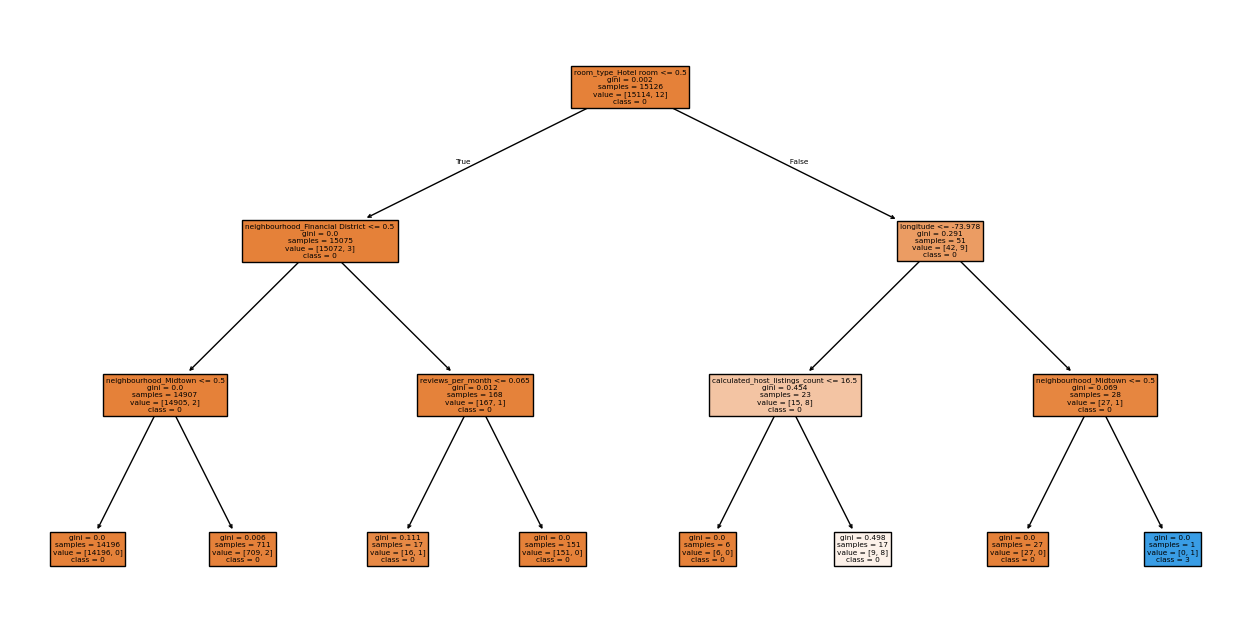

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


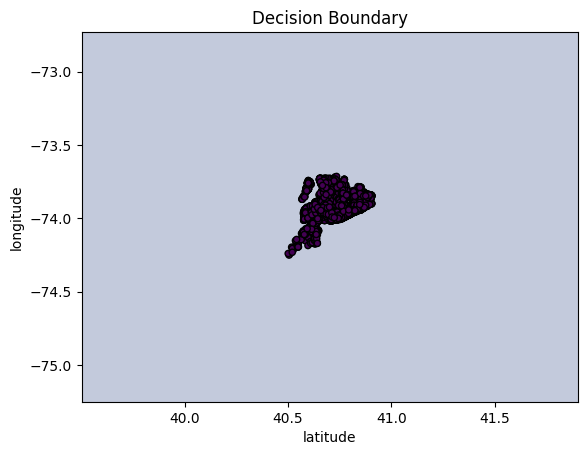

In [8]:
# A1: Entropy
print("A1: Entropy of price bins:", entropy(y_binned))

# A2: Gini Index
print("A2: Gini Index of price bins:", gini_index(y_binned))

# A3: Best Feature
best_feat, best_gain = best_feature_to_split(X_encoded, y_binned)
print("A3: Best Feature:", best_feat, "with Info Gain:", best_gain)

# A4: Equal-width binning
print("Equal Width Binning (4 bins):")
print(binning(df_clean['price'], bins=4, method='width').head(10))

# Equal-frequency binning
print("\nEqual Frequency Binning (4 bins):")
print(binning(df_clean['price'], bins=4, method='frequency').head(10))


# A5 & A6: Train and Plot Decision Tree
clf = train_decision_tree(X_encoded, y_binned, max_depth=3)
plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=X_encoded.columns, class_names=[str(i) for i in np.unique(y_binned)], filled=True)
plt.show()

# A7: Decision Boundary with 2 Features
numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns[:2]
X_2feat = X_encoded[numeric_cols]
clf_2feat = train_decision_tree(X_2feat, y_binned, max_depth=3)
plot_decision_boundary(clf_2feat, X_2feat, y_binned, numeric_cols)